In [29]:
import numpy as np
import pandas as pd
import math
from astropy.io import fits
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

data, header = fits.getdata('C:/Users/ronald.sumners/Desktop/VariableStarAnalysis/M3_a60-026_bdn_r1_r2_may29_r3_r4.fit', header = True)
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
mask = np.ones(data.shape, dtype=bool)
mask[500:3500, 500:3500] = False
#mask[2000:2500, 1500:2000] = True

daofind = DAOStarFinder(fwhm=5.0, threshold=6000, sky = 5363)

sources = daofind(data, mask=mask).to_pandas()
print(sources)

starMask = np.zeros(sources['xcentroid'].shape, dtype=bool)

for i in range(len(sources['id'])):
    
    x = sources['xcentroid'][i]
    y = sources['ycentroid'][i]
    
    xAnalysis = sources['xcentroid'].drop(i)
    yAnalysis = sources['ycentroid'].drop(i)

    if not (xAnalysis.between(x-4, x+4).any() and yAnalysis.between(y-4, y+4).any()):
        starMask[i] = True

newSources = sources.loc[starMask].reset_index(drop=True)


        id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
0        1  2198.951630   499.702847   0.726879   -0.159841    0.078310    49   
1        2  1381.515263   502.270683   0.687866   -0.101137    0.009248    49   
2        3  1803.045731   503.031345   0.767013   -0.056950    0.064125    49   
3        4   991.131191   509.039717   0.776120   -0.003162    0.017847    49   
4        5  2462.255441   509.008464   0.721637   -0.200348    0.020514    49   
...    ...          ...          ...        ...         ...         ...   ...   
1266  1267   631.518850  3490.641664   0.611840    0.720363   -0.103959    49   
1267  1268   860.073293  3491.869218   0.640071    0.596004   -0.040648    49   
1268  1269  2698.779339  3495.817567   0.701869    0.101010   -0.049252    49   
1269  1270  1636.088910  3498.355773   0.648285    0.411939   -0.057643    49   
1270  1271  2754.876163  3499.274304   0.647934    0.090409   -0.034938    49   

       sky          peak   

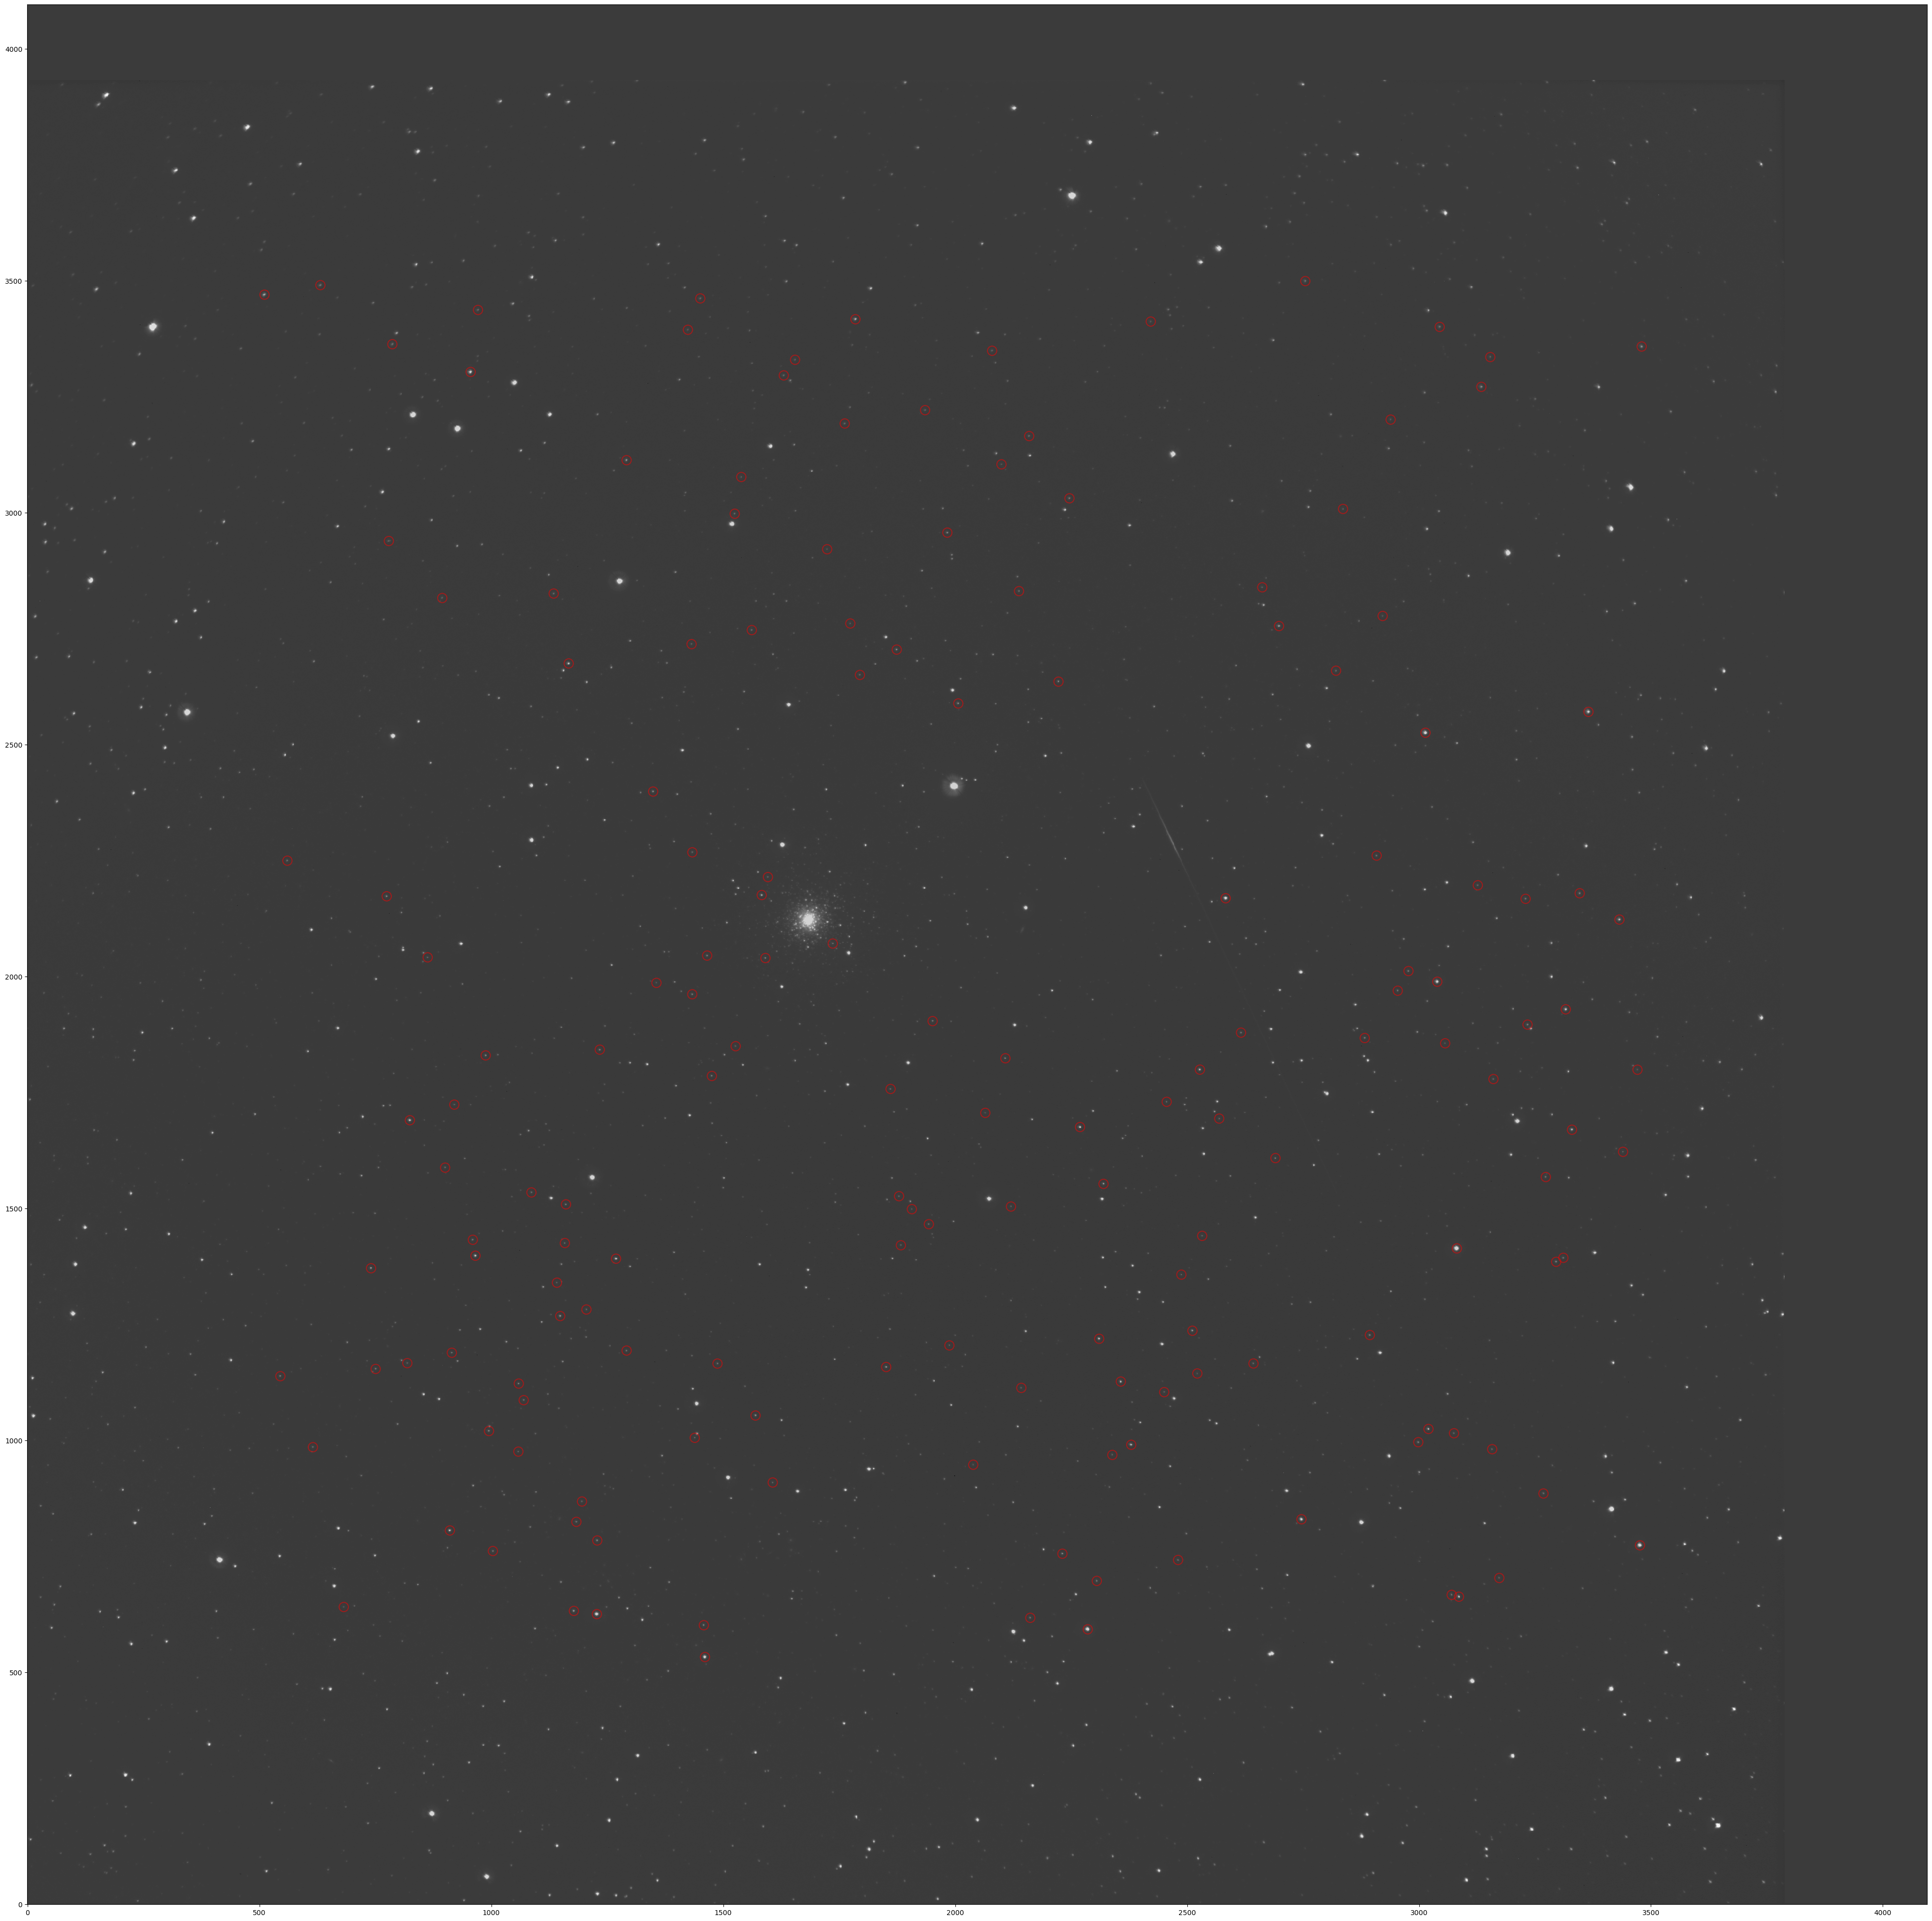

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((newSources['xcentroid'], newSources['ycentroid']))
apertures = CircularAperture(positions, r=10.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='gray', origin='lower', norm=norm,
           interpolation='nearest')
plt.rcParams["figure.figsize"] = (50,50)
apertures.plot(color='red', lw=1.5, alpha=0.5)

In [34]:
from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry
import os

goodStars = newSources[['xcentroid', 'ycentroid']]


directory = 'C:/Users/ronald.sumners/Desktop/VariableStarAnalysis'
obj = 0

mag = []
name = []
SN = []
Error = []
X = []
Y = []

def calc_phot_table(directory, goodStars, obj):
    total_phot = pd.DataFrame()
    positions = list(zip(goodStars['xcentroid'], goodStars['ycentroid']))

    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in=8, r_out=12)
    for file in os.listdir(directory):
        if file.endswith('.fit'):
            f = os.path.join(directory, file)

            data, header = fits.getdata(f, header = True)
            aperstats = ApertureStats(data, annulus_aperture)

            bkg_mean = aperstats.mean

            phot_table = aperture_photometry(data, aperture)
            for col in phot_table.colnames:
                phot_table[col].info.format = '%.8g'  # for consistent table output

            aperture_area = aperture.area_overlap(data)
            annulus_area = annulus_aperture.area_overlap(data)
            aperture_total = aperstats.sum

            total_bkg = bkg_mean * aperture_area

            phot_bkgsub = phot_table['aperture_sum'] - total_bkg

            phot_table['aperture_area'] = aperture_area
            phot_table['annulus_area'] = annulus_area
            phot_table['bkg_mean'] = bkg_mean
            phot_table['total_bkg'] = total_bkg
            phot_table['aperture_sum_bkgsub'] = phot_bkgsub
            
            phot = phot_table.to_pandas()
            total_phot = pd.concat([total_phot, phot], ignore_index = True)
    return total_phot

total_phot = calc_phot_table(directory, goodStars, obj)

flag = []
index = []
numberStarsBeforeRemove = len(goodStars['xcentroid'])
for i in range(len(total_phot['aperture_sum_bkgsub'])):  
    if ((1.42*total_phot['aperture_sum_bkgsub'][i])/60) < 0:
        flag.append(i%numberStarsBeforeRemove)
        index.append(i)

flag = list(set(flag))

print(len(total_phot['xcenter']), numberStarsBeforeRemove)
for entry in flag:
    indicies = np.arange(entry, len(total_phot['xcenter']), numberStarsBeforeRemove)
    total_phot = total_phot.drop(indicies)
    
total_phot = total_phot.reset_index()
#print(total_phot)
numberStars = len(goodStars['xcentroid']) -len(flag)

for i in range(len(total_phot['aperture_sum_bkgsub'])):
    X.append(total_phot['xcenter'][i])
    Y.append(total_phot['ycenter'][i])
    mag.append(21-2.5*math.log10((1.42*total_phot['aperture_sum_bkgsub'][i])/60))
    name.append(f'M3-{(i%numberStars)+1}')
    SigNoiseCalc = total_phot['aperture_sum'][i]/math.sqrt((total_phot['aperture_sum'][i] + total_phot['aperture_area'][i]*(1+(total_phot['aperture_area'][i]/total_phot['annulus_area'][i]))*(total_phot['bkg_mean'][i]+0+15.00992)))
    SN.append(SigNoiseCalc)
    Error.append(1.086/SigNoiseCalc)

photStars = pd.DataFrame()
photStars['X'] = X
photStars['Y'] = Y
photStars['Mag'] = mag
photStars['Name'] = name
photStars['S/N'] = SN
photStars['Error(T)'] = Error


photStars['#'] = np.tile(np.arange(1, numberStars+1, 1), int(len(photStars['X'])/numberStars))

photStars = photStars.rename(columns={'#': '#', 'xcenter': 'X', 'ycenter': 'Y', 'Mag': 'Mag', 'Name': 'Name', 'S/N': 'S/N', 'Error(T)': 'Error(T)'})
print(photStars)
photStars.to_csv('M3-AutoPhotometry.csv')

17098 103
                 X            Y        Mag    Name          S/N  Error(T)    #
0      1460.608546   532.685845   9.670335    M3-1  1252.035669  0.000867    1
1      1795.698363   562.403615  12.847247    M3-2   710.147474  0.001529    2
2       681.902735   640.628773  12.818415    M3-3   712.965484  0.001523    3
3      3086.107305   662.812238  10.434598    M3-4   985.776592  0.001102    4
4      3070.419925   666.871079  11.907436    M3-5   765.690602  0.001418    5
...            ...          ...        ...     ...          ...       ...  ...
16927  1960.303375  3370.855572  12.971218   M3-98   588.871849  0.001844   98
16928  1423.775224  3394.379228  12.524493   M3-99   610.696792  0.001778   99
16929  3044.604439  3400.563532  11.779393  M3-100   664.958378  0.001633  100
16930   510.973793  3470.051046  10.273551  M3-101   967.759604  0.001122  101
16931  2754.876163  3499.274304  11.373909  M3-102   715.476442  0.001518  102

[16932 rows x 7 columns]
